<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---

## **Day07 Afternoon: Variational Autoencoders**

> Indented block



# Introduction

We are going to build a linear and convolutional VAE for the chest medmnist dataset.

## 0.1 Installing MedMNIST

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=1c6dc86c999ccd58e22db438e9d4e15f4aed7949a98b318d519f528668139d56
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


## 0.2 Import packages

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import matplotlib.pyplot as plt

## 0.3 Download the dataset

Tip: there are often examples in the README files:

https://github.com/MedMNIST/MedMNIST/blob/main/README.md

I learnt how to do this using the example in

https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

In [3]:
data_flag = 'chestmnist'
download = True

batch_size = 32

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*batch_size, shuffle=False)



100%|██████████| 82802576/82802576 [00:03<00:00, 20835602.37it/s]


Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


## 0.4 Check the dataset

It's always a good idea to check the dataset before using it.

According to https://medmnist.com/, the dataset should consist of 28x28 images. The chest class has 112,120 images with splits for:

- training	(78,468 images)
- validation (11,219 images)
- testing (22,433 images)

__Can you:__

1. Check the number of batches in the dataloader? (Hint: check the length)
2. Get the first batch of images out of the dataloader?
3. Plot the first image in the batch?
4. How many pixels does an image contain?
5. What is the range of the images?


Batch size: 32
Batches:<bound method DataLoader.__len__ of <torch.utils.data.dataloader.DataLoader object at 0x7863346a3790>>
Num images: 78496

Image shape: torch.Size([32, 1, 28, 28])
Pixels:784
Range: max, 0.9450980424880981 min,0.0


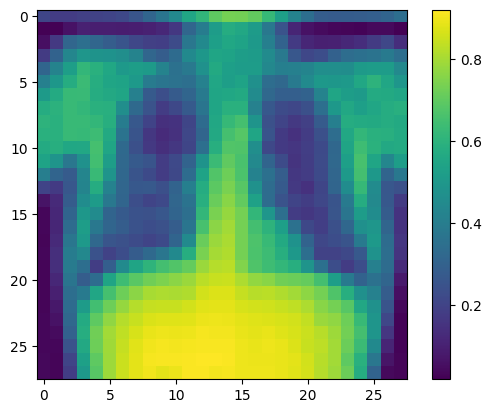

In [4]:
print(train_loader)
print('Batch size: '+str(train_loader.batch_size))
print('Batches:'+str(train_loader.__len__))  # Check the number of batches
print('Num images: '+str(train_loader.batch_size*train_loader.__len__()))
print()

  # Get the first batch of images
images, labels = next(iter(train_loader))

print('Image shape: '+str(images.shape))  # NOTE: The shape is n_ims, n_channels, img_dims

plt.imshow(images[0].squeeze())  # Plot the first image in the batch
plt.colorbar()

print('Pixels:'+str(images.shape[2]*images.shape[3]))  # How many pixels are in the image
print('Range: max, '+str(float(images.max()))+' min,'+str(float(images.min())))


## 1.1 The Encoder

The encoder takes an image and develops a latent vector. Use Linear layers and ReLU activation functions to generate the Mu and Sigma latent vectors.

**In the**
\_\_init\_\_()
**function...**

1. How many nodes should the first layer have?
2. How would you choose the dimensionality reduction schedule?
3. Design layers to generate latent vectors. Do they have activation functions?

**In the**
forward()
**function...**

1. Can you reshape the image to a vector?
2. Can you Implement the latent vectors (mu/sigma) so they are returned with the correct values?


In [5]:
class VAE_Encoder(nn.Module):  # The Encoder inherits the properties of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''
    super(VAE_Encoder, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Linear(784,512,bias=False),  # How many nodes should the first layer have?
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Linear(512,256,bias=False),  # How would you choose a dimensionality reduction schedule?
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(256,128,bias=False),   # How would you choose a dimensionality reduction schedule?
        nn.ReLU()
    )

    self.layerMu = nn.Sequential(
        nn.Linear(128, 16),
        # Does this need an activation?
    )

    self.layerSigma = nn.Sequential(
        nn.Linear(128, 16),
        # Does this need an activation?
    )

  def forward(self, x):  # Custom pytorch modules should follow this structure
    '''
    x: [float] the MNIST image
    '''

    x = torch.flatten(x, start_dim=1)  # Reshape the input into a vector (nD to 1D)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    mu = self.layerMu(x) # Implement Mu
    sigma = torch.exp(self.layerSigma(x))# Implement Sigma
    return mu, sigma


## 1.2 Encoding an image

The encoder will take an image and generate 2 latent vectors (mu/sigma). It is important to show that the encoder works correcly.

**Can you**

1. Get the first image from the first batch?
2. Run the image through the encoder?
3. Are the elements of mu positive and negative?
4. Are the elements of sigma all positive?

**If the answer to questions 3 and 4 is not "Yes", then return to the encoder and make corrections.**

In [6]:
encoder = VAE_Encoder()
images, labels = next(iter(train_loader))
print(images[0].shape)
  # Get the first batch from the dataloader
  # Get the first image from the batch
mu, sigma = encoder(images[0].unsqueeze(0))


print(mu.detach()) # Check whether the elements are correct?
print(sigma.detach())

torch.Size([1, 28, 28])
tensor([[-0.0926, -0.0324,  0.0509,  0.0161,  0.0584, -0.0054,  0.1036, -0.0222,
         -0.0013,  0.1194, -0.1082,  0.0082,  0.0093,  0.0425, -0.0432,  0.0841]])
tensor([[0.9747, 0.9907, 1.0575, 1.0478, 1.0582, 1.0035, 1.0971, 0.9810, 0.9772,
         1.0403, 0.9870, 0.9275, 1.0003, 0.9871, 1.0454, 1.0538]])


## 1.3 The Decoder

The decoder takes a latent vector and develops an image. Use Linear layers and ReLU activation functions to generate an image.

Remember, if you implement the stochastic sampling layer in the decoder, then you won't be able to make deterministic preditions.

**In the**
\_\_init\_\_()
**function...**

1. Should the latent vector layer have an activation function?
2. How would you choose the dimensionality expansion schedule?
3. What activation function should the output layer have?

**In the**
forward()
**function...**

1. Can you reshape the vector to an image?


In [7]:
class VAE_Decoder(nn.Module):  # The Encoder inherits the properties of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(VAE_Decoder, self).__init__()

    self.layerLatent = nn.Sequential(
        nn.Linear(16, 128), # Choose the dimensionality expansion schedule
        # Does the latent vector have an activation?
    )

    self.layer1 = nn.Sequential(
        nn.Linear(128, 256,bias=False), # Choose the dimensionality expansion schedule
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Linear(256, 512, bias=False),  # Choose the dimensionality expansion schedule
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(512, 784, bias=False),  # Choose the dimensionality expansion schedule
         # What activation for the output layer?
        nn.Sigmoid()
    )

  def forward(self, z):  # Custom pytorch modules should follow this structure
    '''
    x: [float] the MNIST image
    '''

    z = self.layerLatent(z)
    z = self.layer1(z)
    z = self.layer2(z)
    z = self.layer3(z)
    return z.reshape((-1,1,28,28))# Reshape the vector into an image



## 1.4 Decoding a latent vector

The encoder will take a latent vector (z) and generate an image. It is important to show that the encoder works correcly.

**Can you**

1. Generate a vector of zeros with the correct shape?
2. Run the latent vector through the decoder?
3. Is the image the correct shape (1,1,28,28)?
4. Does the image look like random noise?

**If the answer to questions 3 and 4 is not "Yes", then return to the decoder and make corrections.**

Image shape: torch.Size([1, 1, 28, 28])


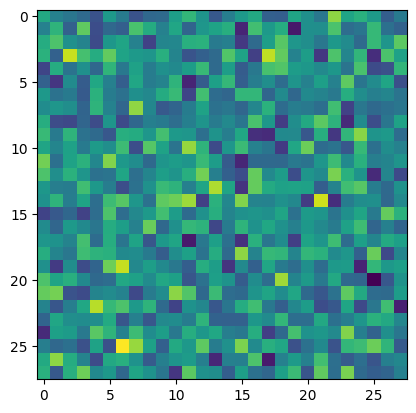

In [8]:
decoder = VAE_Decoder()

z = torch.zeros(1,16)  # Generate a random vector with the correct shape
image = decoder(z)  # Run the vector through the decoder

print('Image shape: '+str(image.shape))  # Check the shape of the image

plt.imshow(image.detach().cpu().squeeze())  # Does the image look like random noise?


## 2.1 Autoencoder

The output of the encoder is two latent vectors, mu and sigma. Together these represent the latent space distribution because they define a Gaussian distribution.

Now we build the autoencoder. The autoencoder uses an *encoder* to generate the latent mu and sigma and a *decoder* to generate an image using the latent vector z. The latent vector z is found be stochastic sampling of the latent space distribution.

**In**
sample_latent_space()
**Can you**

1. Define an equation to sample from the latent distribution?

**In**
forward()
**Can you**

1. Take the image and generate the latent vectors mu & sigma?
2. Take the latent vectors mu & sigma and generate the latent vector sample?
3. Take the latent vector sample and generate the reconstructed image?



In [9]:
class VAE(nn.Module):
  def __init__(self, device):
    '''
    Class combines the Encoder and the Decoder with a VAE latent space.
    '''
    super(VAE, self).__init__()
    self.device = device
    self.encoder = VAE_Encoder()
    self.decoder = VAE_Decoder()
    self.distribution = torch.distributions.Normal(0, 1)  # Sample from N(0,1)

  def sample_latent_space(self, mu, sigma):
    z = mu + sigma*self.distribution.sample(mu.shape).to(self.device) ## (1) Sample the latent distribution
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()  # A term, which is required for regularisation
    return z, kl_div

  def forward(self, x):
    '''
    x - [float] A batch of images from the data-loader
    '''

      ## (1) Generate the latent vectors Mu and Sigma
    mu, sigma = self.encoder(x)
      ## (2) Generate the latent vector sample
    z, kl_div = self.sample_latent_space(mu, sigma)
      ## (3) Generate the reconstructed image
    z = self.decoder(z)
    return z, kl_div

print('done')

done


## 2.2 Generating a reconstruction

It is important to test that the VAE works as expected.

torch.Size([1, 28, 28])


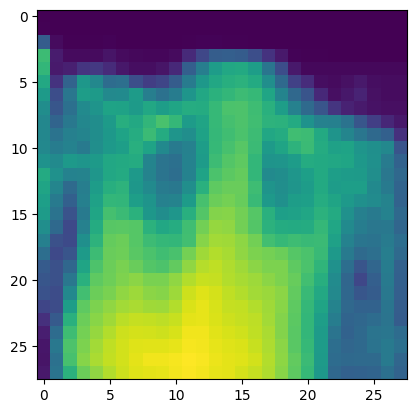

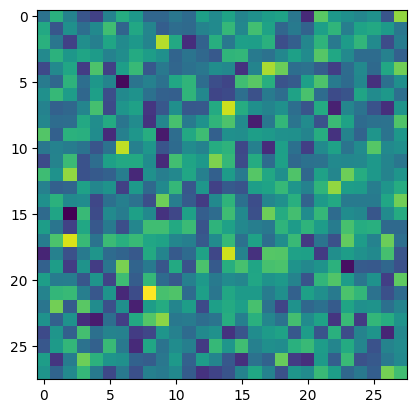

In [10]:
vae = VAE('cpu')

images, labels = next(iter(train_loader))  # Get the first batch of images
print(images[0].shape)  # Get the first image from the batch
recon, _ = vae(images[10].unsqueeze(0))  # Are mu and sigma correct

plt.figure(); plt.imshow(images[0].squeeze())
plt.figure(); plt.imshow(recon.cpu().detach().squeeze())


## 3.1 Training the VAE

In [11]:
def train(autoencoder, data, kl_div_on=True, epochs=10, device='cpu'):
  opt = torch.optim.Adam(autoencoder.parameters())
  for epoch in range(epochs):  # Run data over numerous epochs
    for batch, label in tqdm(data):  # Iterate over the batches of images and labels
      batch = batch.to(device)  # Send batch of images to the GPU
      opt.zero_grad()  # Set optimiser grad to 0
      x_hat, KL = autoencoder(batch)  # Generate predicted images (x_hat) by running batch of images through autoencoder
      loss = ((batch - x_hat)**2).sum() + KL  # Calculate combined loss
      loss.backward()  # Back-propagate
      opt.step()  # Step the optimiser
  return autoencoder  # Return the trained autoencoder (for later analysis)

device = 'cuda'

dims_latent = 2  # Maybe increase this an try the t-sne algorithm for visualisation?!
vae = VAE(device).to(device)
vae = train(vae, train_loader, epochs=10, device=device)

print('done')

100%|██████████| 2453/2453 [00:15<00:00, 156.05it/s]

done


## 4.1 Mode collapse

Generate some images with the trained VAE. Do you notice that all the recons look similar?

Generative models have a tendency towards mode collapse, where they generate the "average" of the dataset rather than a meaningful recon.

torch.Size([64, 1, 28, 28])


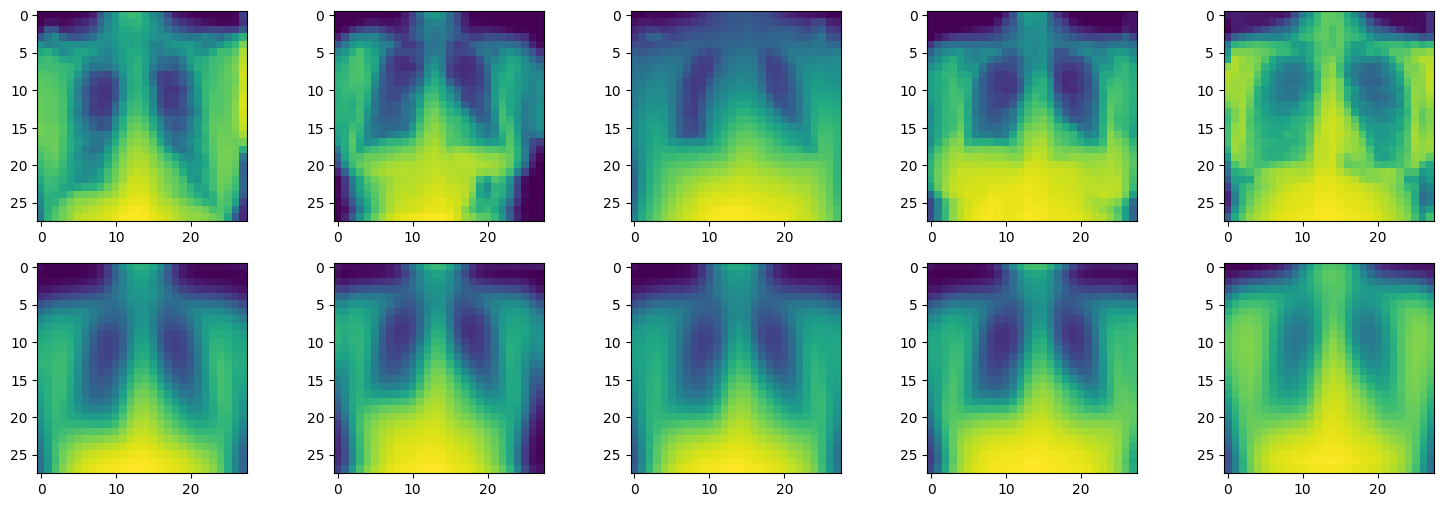

In [12]:
images, labels = next(iter(test_loader))  # Get the first batch of images
print(images.shape)  # Get the first image from the batch

_, ax = plt.subplots(2, 5, figsize=[18.5, 6])
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
  recon, _ = vae(images[idx].unsqueeze(0).cuda())  # Are mu and sigma correct
  ax[0, n].imshow(images[idx].squeeze())
  ax[1, n].imshow(recon.cpu().detach().squeeze())


## 4.2 Convolutional VAE

By increasing the complexity of the model we can generate more complex images. The best starting point is to replace Linear layers with Conv layers.

In a convolutional Encoder:
- Increase the number of channels using __Conv2D__
- Compress the spatial dimensions are compressed using __MaxPool2d__
- It is important to pad the starting image to a power of two so the dimensionality reduction works correctly.

In [13]:
class VAE_Encoder_Conv(nn.Module):
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''
    super(VAE_Encoder_Conv, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,  20, 3, padding=3),  # Pad so that image dims are 2^n
        nn.GELU(),
        nn.MaxPool2d(2)
    )  # Dims in 32x32 -> out 16x16

    self.layer2 = nn.Sequential(
        nn.Conv2d(20, 40, 3, padding="same"),
        nn.MaxPool2d(2)
    )  # Dims in 16x16 -> out 8x8

    self.layer3 = nn.Sequential(
        nn.Conv2d(40, 60, 3, padding="same"),
        nn.GELU(),
        nn.MaxPool2d(2)
    )  # Dims in 8x8 -> out 4x4

    self.layerMu = nn.Sequential(
        nn.Conv2d(60, 120, 1),
    )  # Dims in 4x4 -> out 4x4

    self.layerSigma = nn.Sequential(
        nn.Conv2d(60, 120, 1),
    )  # Dims in 4x4 -> out 4x4

  def forward(self, x, print_shape=False):  # Custom pytorch modules should follow this structure
    '''
    x: [float] the MNIST image
    '''

    x = self.layer1(x)
    if print_shape:
      print('L1: '+str(x.shape))
    x = self.layer2(x)
    if print_shape:
      print('L2: '+str(x.shape))
    x = self.layer3(x)
    if print_shape:
      print('L3: '+str(x.shape))
    mu =  self.layerMu(x)
    sigma = torch.exp(self.layerSigma(x))
    return mu, sigma


In [14]:
encoder = VAE_Encoder_Conv()

images, labels = next(iter(train_loader))  # Get the first batch of images
print('Input shape: '+str(images[0].shape))  # Get the first image from the batch
mu, sigma = encoder(images[0].unsqueeze(0), print_shape=True)  # Are mu and sigma correct

print('Mu shape: '+str(mu.detach().shape))
print('Sigma shape:'+str(sigma.detach().shape))

Input shape: torch.Size([1, 28, 28])
L1: torch.Size([1, 20, 16, 16])
L2: torch.Size([1, 40, 8, 8])
L3: torch.Size([1, 60, 4, 4])
Mu shape: torch.Size([1, 120, 4, 4])
Sigma shape:torch.Size([1, 120, 4, 4])


In a convolutional Decoder:
- Decrease the number of channels using __Conv2D__
- Expand the spatial dimensions using __Upsample__
- Dont forget to remove the padding from the output!

In [15]:
class VAE_Decoder_Conv(nn.Module):  # The Encoder inherits the properties of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(VAE_Decoder_Conv, self).__init__()

    self.layerLatent = nn.Sequential(
        nn.Conv2d(120, 60, 1),
        nn.GELU(),
        nn.Upsample(scale_factor=2, mode='nearest')
    )  # Dims in 4x4 -> out 8x8

    self.layer1 = nn.Sequential(
        nn.Conv2d(60, 40, 3, padding='same'),
        nn.GELU(),
        nn.Upsample(scale_factor=2, mode='nearest')
    )  # Dims in 8x8 -> out 16x16

    self.layer2 = nn.Sequential(
        nn.Conv2d(40, 20, 3, padding='same'),
        nn.GELU(),
        nn.Upsample(scale_factor=2, mode='nearest')
    )  # Dims in 16x16 -> out 32x32

    self.layer3 = nn.Sequential(
        nn.Conv2d(20, 1, 3, padding='same'),
        nn.GELU(),
        nn.Sigmoid()
    )  # Dims in 32x32 -> out 32x32

  def forward(self, z, print_shape=False):  # Custom pytorch modules should follow this structure
    '''
    x: [float] the MNIST image
    '''

    z = self.layerLatent(z)
    z = self.layer1(z)
    if print_shape:
      print('L1: '+str(z.shape))
    z = self.layer2(z)
    if print_shape:
      print('L2: '+str(z.shape))
    z = self.layer3(z)
    if print_shape:
      print('L3: '+str(z.shape))
    return z[:,:,2:-2,2:-2]  # Crop the output



Latent shape: torch.Size([1, 120, 4, 4])
L1: torch.Size([1, 40, 16, 16])
L2: torch.Size([1, 20, 32, 32])
L3: torch.Size([1, 1, 32, 32])
Image shape: torch.Size([1, 1, 28, 28])


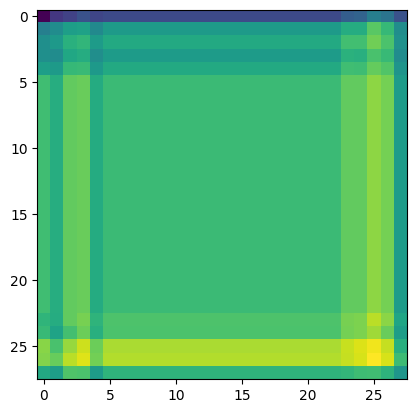

In [16]:
decoder = VAE_Decoder_Conv()

latent_vec = torch.zeros(1,120,4,4)

print('Latent shape: '+str(latent_vec.shape))

recon = decoder(latent_vec, print_shape=True)

print('Image shape: '+str(recon.shape))

plt.imshow(recon.detach().cpu().squeeze())


You don't need to make many changes for Autoencoding though.

An interesting challenge is to explore the effect of changing the spatial/channel dimensions in the latent space.

In [17]:
class VAE_Conv(nn.Module):
  def __init__(self, device):
    '''
    Class combines the Encoder and the Decoder with a VAE latent space.
    '''
    super(VAE_Conv, self).__init__()
    self.device = device
    self.encoder = VAE_Encoder_Conv()
    self.decoder = VAE_Decoder_Conv()
    self.distribution = torch.distributions.Normal(0, 1)  # Sample from N(0,1)

  def sample_latent_space(self, mu, sigma):
    z = mu + sigma * self.distribution.sample(mu.shape).to(self.device)  # Sample the latent distribution
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()  # A term, which is required for regularisation
    return z, kl_div

  def forward(self, x):
    '''
    x - [float] A batch of images from the data-loader
    '''

    mu, sigma = self.encoder(x)  # Run the image through the Encoder
    z, kl_div = self.sample_latent_space(mu, sigma)  # Take the output of the encoder and get the latent vector
    z = self.decoder(z)  # Return the output of the decoder (the predicted image)
    return z, kl_div

print('done')

done


Notice how the appearance of the reconstruction contains correlated noise. This is exactly what we want so that we can achieve visually "correct" appearances.

torch.Size([1, 28, 28])


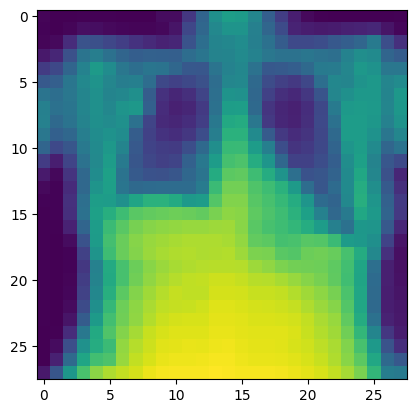

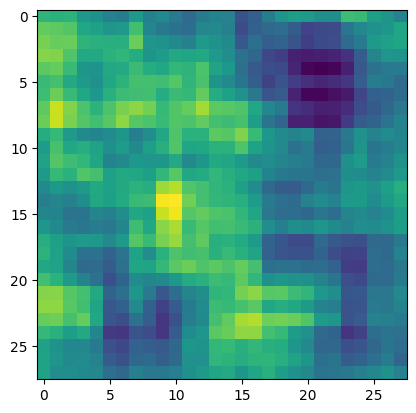

In [18]:
vae = VAE_Conv('cpu')

images, labels = next(iter(train_loader))  # Get the first batch of images
print(images[0].shape)  # Get the first image from the batch
recon, _ = vae(images[10].unsqueeze(0))  # Are mu and sigma correct

plt.figure(); plt.imshow(images[0].squeeze())
plt.figure(); plt.imshow(recon.cpu().detach().squeeze())


In [19]:
def train(autoencoder, data, kl_div_on=True, epochs=10, device='cpu'):
  opt = torch.optim.Adam(autoencoder.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.5)
  for epoch in range(epochs):  # Run data over numerous epochs
    for batch, label in tqdm(data):  # Iterate over the batches of images and labels
      batch = batch.to(device)  # Send batch of images to the GPU
      opt.zero_grad()  # Set optimiser grad to 0
      x_hat, KL = autoencoder(batch)  # Generate predicted images (x_hat) by running batch of images through autoencoder
      loss = ((batch - x_hat)**2).sum() + KL  # Calculate combined loss
      loss.backward()  # Back-propagate
      opt.step()  # Step the optimiser
  return autoencoder  # Return the trained autoencoder (for later analysis)

device = 'cuda'

vae_conv = VAE_Conv(device).to(device)
vae_conv = train(vae_conv.train(True), train_loader, epochs=5, device=device)

print('done')

100%|██████████| 2453/2453 [00:21<00:00, 113.18it/s]

done


torch.Size([64, 1, 28, 28])


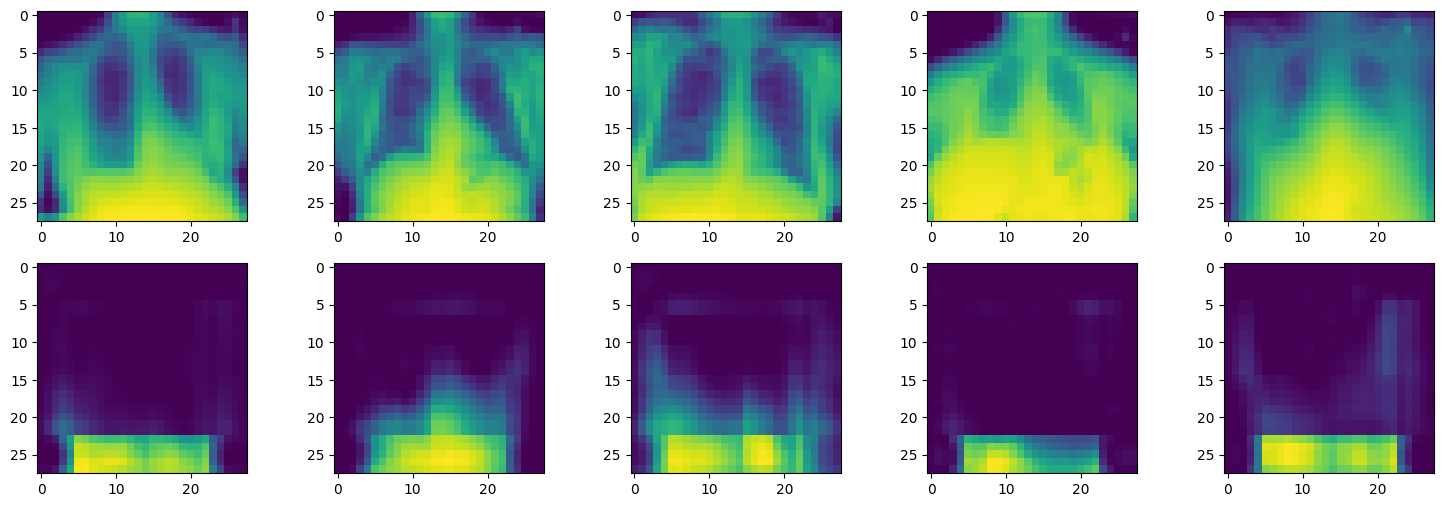

In [21]:
images, labels = next(iter(test_loader))  # Get the first batch of images
print(images.shape)  # Get the first image from the batch
vae_conv1 = vae_conv.eval()

_, ax = plt.subplots(2, 5, figsize=[18.5, 6])
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
  recon, _ = vae_conv(images[idx].unsqueeze(0).cuda())  # Are mu and sigma correct
  ax[0, n].imshow(images[idx].squeeze())
  ax[1, n].imshow(recon.cpu().detach().squeeze())
